In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from gempy import coKriging
from gempy import GridClass
import pandas as pd
from numpy import random
import sklearn.preprocessing as skp
import pymc3 as pm
import theano.tensor as T

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [2]:
SED_f = gp.coKriging.theano_sed()

In [4]:
def init_domain (geomodel, grid, formation):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        down to a certain formation of interest.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
        """
    
        # convert lith block values to int, thats what Miguel suggested
        lith_block_int = np.round(lith_block)
    
        # create the dataframe and populate with data
        d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0]}
        df_cokr = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
        df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
        del df_sgs_grid['index'] # reset indices

        return df_sgs_grid

def init_data(data):   
    """
    Method to get the property data into the form form. Depending on form of Input data a standardization should be 
    added.
    Args:
            pandas.dataframe: Dataframe with Coordinates and property data for n_properties
    Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
    """
    return data

def analyse_data(data):
    """
    Method to get everything out of the Input Data
    """
    # This will be super hard
    
    # method to get variograms and cross variograms
    # get nugget, lags, etc
    # method to get direct and cross covariance functions
    
    return()

def select_closest_points(coord, df):
    """
    Method to select n closest points from the given coordinate to perform Cokriging with reasonable calculation
    time
    Args:
        coord (np.array): coordinates of point
        df (pandas.dataframe): dataframe containing coordinated and properties
    Returns
        df_cut (pandas.dataframe): dataframe containing only the 50 closest points
    """
    
    selected_coord_data = df[['X', 'Y', 'Z']]
    # selected_values_data = df[df.columns.difference(['X', 'Y', 'Z'])].as_matrix()
    
    dist = SED_f(selected_coord_data, coord) # Miguels distance function, applied to input data
    
    for r in range(100, 5000, 100):
        closest_points = (dist < r).any(axis=1)
        if closest_points.sum() > 50:
            break
    
    return closest_points

    
class full_krig (object):
    """
    class containing all data for the complete SGS run
    """
    def __init__(self, geomodel=None, grid=None, data=None, formation=None, ):
        
        # this is all the absolute basic Input data we have
        self.formation=formation
        self.geomodel=geomodel
        self.grid=grid
        self.data=data
        
        # now we create all the other stuff we can get out of that
        
        # create grid for interpolation
        domain_grid=init_domain(geomodel, grid, formation)
        self.domain_grid=domain_grid
        
        # random input data set for testing purposes
        data = create_synthetic_Input_data(n_prop=3, n_samples=100, grid=self.domain_grid)
        self.data=data
        # create input data set (standardization, cut)
        # data=init_data(data)
        # self.data = data
        
        self.n_properties=len(data.columns)-3
        n_samples=len(data)
        self.n_samples=n_samples
        
        # analyze the data for variograms and fitted covariance functions
        # that will be the fun part for the week!
        analysis=analyse_data(data)
        self.analysis=analysis
    
    def perform_sgs(self):
        """
        Method to perform the SGS run, creating a new dataframe with the resulting grid, 
        containing the interpolated data fro the CoKriging
        Args:
            property_data (pandas.datframe): frame containing property data with corresponding X,Y,Z coordinates
            sgs_grid (pandas.dataframe): frame containing grid, meaning all X,Y,Z coordinates in domain 
        Returns:
            Result: Dataframe containg all interpolated values with corresponding coordinates       
        """
        # new dataframe for all results
        results = pd.DataFrame(columns=self.data.columns)  

        # both Input dfs should not be changed
        df_prop_calc = self.data.copy() #copy dataframe for appending results for SGS
        df_sgs_grid_calc = self.domain_grid.copy() #copy of grid frame to delete data

        for i in range(0, len(self.domain_grid)):

            # choose random point from df_sgs_grid_calc
            rand_pos = np.random.randint(0,len(df_sgs_grid_calc))
            random_coord = np.array([df_sgs_grid_calc.loc[rand_pos,'X'],df_sgs_grid_calc.loc[rand_pos,'Y'],df_sgs_grid_calc.loc[rand_pos,'Z']])

            # workaround to turn coord into df to make it work with Miguels Code
            coord_aux={'X':[random_coord[0]], 'Y':[random_coord[1]], 'Z':[random_coord[2]]}
            rand_coord_df=pd.DataFrame(data=coord_aux)

            # delete point from the df sgs_grid_calc
            df_sgs_grid_calc = df_sgs_grid_calc.drop([rand_pos])
            df_sgs_grid_calc = df_sgs_grid_calc.reset_index() # reset indicies
            del df_sgs_grid_calc['index'] #reset indices

            # only select n closest points for Cokriging,best by selection to make it work with miguels code
            df_prop_calc_close = select_closest_points(rand_coord_df, df_prop_calc)

            # perform the CoKriging interpolation on this point
            kriging_results = self.CoKriging() 

            #just for testing purposes, we get this from the Kriging Results
            # good enough, lets see what the Kriging results really look like
            krig_mean = kriging_results[0]
            krig_std = kriging_results[1]

            # set coordinates in result array
            new_interpolated_point = ([random_coord[0], random_coord[1],random_coord[2]])

            # add property interpolation to results array, depends a little bit on form of Kriging results
            for j in range(self.n_properties):
                new_interpolated_point.append(np.random.normal(krig_mean, krig_std))

            # append result to df_prop_calc to use for further SGS
            df_prop_calc.loc[len(df_prop_calc)]=new_interpolated_point

            # append results to final results dataframe that will be returned
            results.loc[len(results)]=new_interpolated_point

        return results
    
    def CoKriging(self, coord_to_inter, df_prop_calc, selection_A):
        '''
        Method to perform Cokriging at one point
        '''
        # for testing
        krig_mean=np.random.randint(1,100)
        krig_std=np.random.randint(1,3)
        
        # more real
        '''
        # Select input data and compute its euclidean distances
        selected_coord_data = df_prop_data[selection][['X', 'Y', 'Z']]
        selected_values_data = df_prop_data[selection][df_prop_data.columns.difference(['X', 'Y', 'Z'])].as_matrix()
        h_A = SED_f(selected_coord_data, selected_coord_data)

        # Select points of grid to interpolate and compute the euclidean distances respect the input data
        selected_grid_to_inter = coord_to_inter 
        h_b = SED_f(selected_coord_data, selected_grid_to_inter)
        
        # If input data is correct, this can stay
        # Compute cross-covariances, I need to tile this properly
        cov_h = coKriging.cross_covariance(trace, h_A, sample=sample,
                                    nuggets=nuggets, n_var=n_var, n_exp=n_exp, n_gaus=n_gauss, ordinary=True)
        cov_b = coKriging.cross_covariance(trace, h_b, sample=sample, nuggets=nuggets, n_var=n_var, n_exp=n_exp,
                                    n_gaus=n_gauss,
                                    ordinary=True)

        # If input data is correct, this can stay
        # Solve kriging system
        k_weights = np.linalg.solve(cov_h, cov_b)

        # dont know what this is and if its necessary if i do not take random covariance function and if I only do 
        # it at one point
        # Number of points to interpolate
        npti = selected_grid_to_inter.shape[0]

        # dont know what this is and if its necessary if i do not take random covariance function and only do it at 
        # one point - I need something different here I guess
        # Repeat the input data for every point to interpolate
        svd_tmp = np.tile(np.repeat(selected_values_data, npti, axis=1), (n_var, 1))

        # this should work
        # Sol ordinary kriging mean
        krig_mean = (svd_tmp * k_weights[:-n_var]).sum(axis=0)

        # this should work
        # Sol ordinary kriging std
        krig_std = svd_tmp.std(axis=0) - (k_weights * cov_b)[:-n_var].sum(axis=0) +\
                (k_weights * cov_b)[-n_var:].sum(axis=0)
        '''
        
        return (krig_mean, krig_std)
    
        ''''''

    def select_closest_points(coord, df):
        """
        Method to select n closest points from the given coordinate to perform Cokriging with reasonable calculation
        time
        Args:
            coord (np.array): coordinates of point
            df (pandas.dataframe): dataframe containing coordinated and properties
        Returns
            df_cut (pandas.dataframe): dataframe containing only the 50 closest points
        """

        selected_coord_data = df[['X', 'Y', 'Z']]
        # selected_values_data = df[df.columns.difference(['X', 'Y', 'Z'])].as_matrix()

        dist = SED_f(selected_coord_data, coord) # Miguels distance function, applied to input data

        # rgiht now this moves in "steps" and can thus contain more than 50 values
        for r in range(100, 5000, 100):
            closest_points = (dist < r).any(axis=1)
            if closest_points.sum() > 50:
                break

        return closest_points
    
    def build_cov_matrix(self):
        '''
        Method to build the covariance matrix by using the analyzed data.
        '''
        # this will also be super hard to do
        
        return cov_matrix

In [5]:
def create_synthetic_Input_data(n_prop, n_samples, grid):
    '''
    This Part is used to create synthetic Input data. It is possible to vary the number of properties
    and the number of samples. Right now every assigned value is a random value between 0 and 100.
    Data is thus in no way spatially correlated, which makes the Kriging kind of useless, but works for
    testing purposes. Only an isotopic case is realized. Max 10 properties can be used due to a.
    Args: 
        n_prop (int): Number of properties that we have data for
        n_samples (int): Number of sample locations, were we have data for every property (isotopic)
    Returns:
        df_prop(pandas.dataframe): dataframe containing x,y,z coordinates and data for n properties
    '''
    # copy to leave original grid intact
    data_loc_aux = grid.copy()

    # create dataframe with coordinates and n properties
    d = ['X', 'Y', 'Z']
    df_prop = pd.DataFrame(columns=d)
    df_prop

    a=['prop1','prop2','prop3','prop4', 'prop5','prop6','prop7','prop8','prop9','prop10']

    for t in range (n_prop):
        df_prop[a[t]]=""

    df_prop

    for i in range(n_samples):
            # choose random point from df_sgs_grid_calc
            rand_pos = np.random.randint(0,len(data_loc_aux))
            random_coord = np.array([data_loc_aux.loc[rand_pos,'X'],data_loc_aux.loc[rand_pos,'Y'],data_loc_aux.loc[rand_pos,'Z']])

            # delete point from the df sgs_grid_calc
            data_loc_aux = data_loc_aux.drop([rand_pos])
            data_loc_aux = data_loc_aux.reset_index() # reset indicies
            del data_loc_aux['index'] #reset indices

            # pick random coordinate from grid
            data_point=([random_coord[0], random_coord[1], random_coord[2]])

            # put random data in 
            for r in range(n_prop):
                data_point.append(np.random.randint(1,100))

            df_prop.loc[i]=data_point
            # create random data for the properties

    return df_prop

In [6]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_interfaces") # importing point-positional interface data

In [7]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')
#print(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [8]:
lith_block, fault_block = gp.compute_model(interp_data)

In [9]:
sgs=full_krig(geomodel=lith_block[0], grid=geo_data.grid, formation=3)

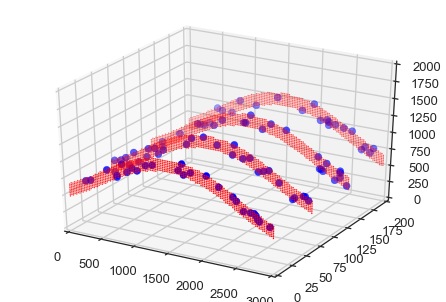

In [10]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=sgs.domain_grid.X,ys=sgs.domain_grid.Y,zs=sgs.domain_grid.Z, c='red', s=1, cmap='prism')
ax.scatter3D(xs=sgs.data.X,ys=sgs.data.Y,zs=sgs.data.Z, c='blue', s=50)

In [11]:
results=sgs.perform_sgs()

TypeError: CoKriging() missing 3 required positional arguments: 'coord_to_inter', 'df_prop_calc', and 'selection_A'

In [ ]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=results.X,ys=results.Y,zs=results.Z, c=results.prop1, s=1, cmap='prism')
ax.scatter3D(xs=sgs.data.X,ys=sgs.data.Y,zs=sgs.data.Z, c='blue', s=50)